In [1]:
from datetime import date, timedelta
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from pylr2 import regress2
import rioxarray as rxr

In [2]:
from src.data import spark_postgis
from src import constants

In [3]:
spark = spark_postgis.get_spark()

23/09/23 09:48:01 WARN Utils: Your hostname, sherwood resolves to a loopback address: 127.0.1.1; using 128.232.93.0 instead (on interface enp193s0f0np0)
23/09/23 09:48:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/ah2174/gedi-disturbance/venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ah2174/.ivy2/cache
The jars for the packages stored in: /home/ah2174/.ivy2/jars
org.apache.sedona#sedona-python-adapter-3.0_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
net.postgis#postgis-jdbc added as a dependency
net.postgis#postgis-geometry added as a dependency
org.postgresql#postgresql added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-f3bbd2d1-54b0-4deb-ac76-16b75989e712;1.0
	confs: [default]
	found org.apache.sedona#sedona-python-adapter-3.0_2.12;1.3.1-incubating in central
	found org.locationtech.jts#jts-core;1.18.2 in central
	found org.wololo#jts2geojson;0.16.1 in central
	found org.apache.sedona#sedona-core-3.0_2.12;1.3.1-incubating in central
	found org.apache.sedona#sedona-common;1.3.1-incubating in central
	found org.apache.sedona#sedona-sql-3.0_2.12;1.3.1-incubating in central
	found org.scala-lang.modules#scala-collection-compat_2.12;2.5.0 in central
	found org.data

23/09/23 09:48:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/09/23 09:48:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/09/23 09:48:03 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/09/23 09:48:03 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [4]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf, col
degrade_sdf = spark.read.parquet((constants.RESULTS_PATH / "gedi_degradation_radd_singlelayer").as_posix())
@udf(returnType=IntegerType())
def get_days(time_delta):
  return time_delta.days

degrade_sdf = degrade_sdf.withColumn("time_diff", (degrade_sdf["t2_absolute_time"] - degrade_sdf["t1_absolute_time"]))
degrade_sdf = degrade_sdf.withColumn("time_diff", get_days(col("time_diff")))
radd_df = gpd.GeoDataFrame(degrade_sdf.toPandas(), geometry="t2_geom").copy()
radd_df.loc[radd_df.control_disturbance > 0, "sample_grp"] = "control"
# Note: points may have a control disturbance as well as a measured disturbance.
# in that case, we include them in the treatment group; we don't care that they
# were also disturbed at another, unmeasured time.
radd_df.loc[radd_df.measured_disturbance > 0, "sample_grp"] = "treatment"
print(len(radd_df))
print(len(radd_df[radd_df["sample_grp"] == "treatment"]))
print(len(radd_df[radd_df["sample_grp"] == "control"]))

41956
7244
34712


In [5]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf, col
degrade_sdf = spark.read.parquet((constants.RESULTS_PATH / "gedi_degradation_afc_2022").as_posix())
@udf(returnType=IntegerType())
def get_days(time_delta):
  return time_delta.days

degrade_sdf = degrade_sdf.withColumn("time_diff", (degrade_sdf["t2_absolute_time"] - degrade_sdf["t1_absolute_time"]))
degrade_sdf = degrade_sdf.withColumn("time_diff", get_days(col("time_diff")))
afc_df = gpd.GeoDataFrame(degrade_sdf.toPandas(), geometry="t2_geom").copy()
afc_df.loc[afc_df.control_disturbance > 0, "sample_grp"] = "control"
# Note: points may have a control disturbance as well as a measured disturbance.
# in that case, we include them in the treatment group; we don't care that they
# were also disturbed at another, unmeasured time.
afc_df.loc[afc_df.measured_disturbance > 0, "sample_grp"] = "treatment"
print(len(afc_df))
print(len(afc_df[afc_df["sample_grp"] == "treatment"]))
print(len(afc_df[afc_df["sample_grp"] == "control"]))

58753
3983
54770


7244
34712
7244
-0.23044695593855355
3983
54770
3983


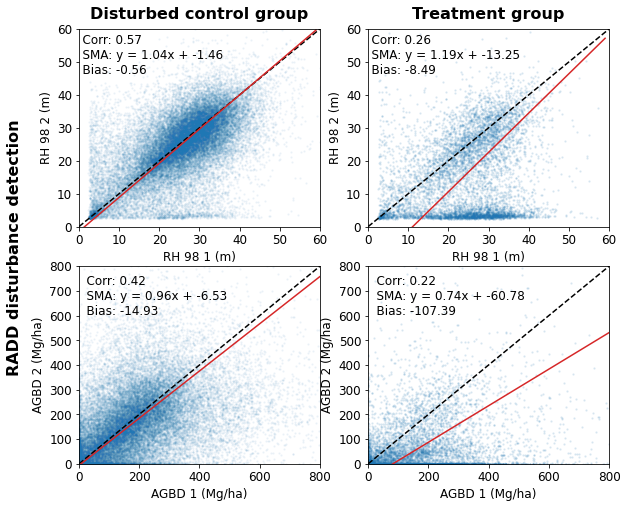

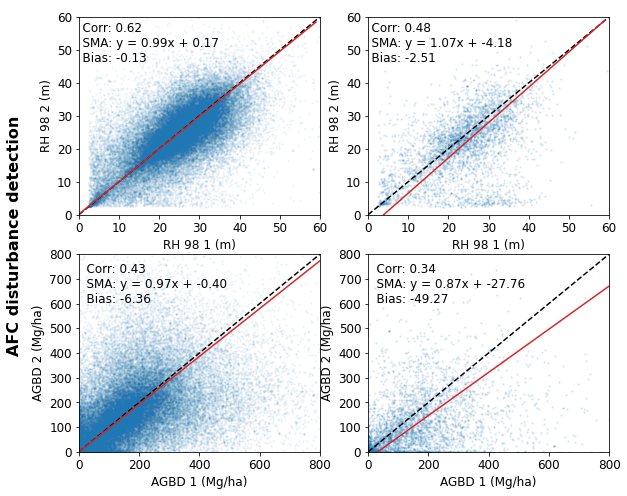

<Figure size 432x288 with 0 Axes>

In [7]:

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9.5,8))

degrade_df = radd_df

xmax = 60

data = degrade_df[degrade_df.sample_grp == "control"]
axi = ax[0][0]
imi = axi.scatter(data.t1_rh_98_a0, data.t2_rh_98_a0, color="tab:blue", alpha=0.05, s=2)
axi.plot([0, xmax], [0, xmax], color='black', linestyle='dashed')
res = regress2(data.t1_rh_98_a0, data.t2_rh_98_a0, _method_type_2="reduced major axis")
xs = np.arange(xmax)
axi.plot(xs, res["intercept"] + res["slope"] * xs, color="tab:red")
axi.set_xlim(left=0, right=xmax)
axi.set_ylim(bottom=0, top=xmax)
axi.set_xlabel("RH 98 1 (m)", fontsize=12)
axi.set_ylabel("RH 98 2 (m)", fontsize=12)
axi.set_title("Disturbed control group", fontsize=16, pad=10, fontweight='bold')
axi.text(-3, xmax+3, f"""
    Corr: {data.t1_rh_98_a0.corr(data.t2_rh_98_a0):.2f}
    SMA: y = {res['slope']:.2f}x + {res['intercept']:.2f}
    Bias: {(data.t2_rh_98_a0 - data.t1_rh_98_a0).mean():.2f}
""", verticalalignment='top', fontsize=12)
axi.tick_params(axis='both', which='major', labelsize=12)


data = degrade_df[degrade_df.sample_grp == "treatment"]
print(len(data))
axi = ax[0][1]
imi = axi.scatter(data.t1_rh_98_a0, data.t2_rh_98_a0, color="tab:blue", alpha=0.1, s=2)
axi.plot([0, xmax], [0, xmax], color='black', linestyle='dashed')
res = regress2(data.t1_rh_98_a0, data.t2_rh_98_a0, _method_type_2="reduced major axis")
xs = np.arange(xmax)
axi.plot(xs, res["intercept"] + res["slope"] * xs, color="tab:red")
axi.set_xlim(left=0, right=xmax)
axi.set_ylim(bottom=0, top=xmax)
axi.set_xlabel("RH 98 1 (m)", fontsize=12)
axi.set_ylabel("RH 98 2 (m)", fontsize=12)
axi.set_title("Treatment group", fontsize=16, pad=10, fontweight='bold')
axi.text(-3, xmax+3, f"""
    Corr: {data.t1_rh_98_a0.corr(data.t2_rh_98_a0):.2f}
    SMA: y = {res['slope']:.2f}x + {res['intercept']:.2f}
    Bias: {(data.t2_rh_98_a0 - data.t1_rh_98_a0).mean():.2f}
""", fontsize=12,
        verticalalignment='top')
axi.tick_params(axis='both', which='major', labelsize=12)

xmax = 800
data = degrade_df[degrade_df.sample_grp == "control"]
print(len(data))
axi = ax[1][0]
imi = axi.scatter(data.t1_agbd_a0, data.t2_agbd_a0, color="tab:blue", alpha=0.05, s=2)
axi.plot([0, xmax], [0, xmax], color='black', linestyle='dashed')
res = regress2(data.t1_agbd_a0, data.t2_agbd_a0, _method_type_2="reduced major axis")
xs = np.arange(xmax)
axi.plot(xs, res["intercept"] + res["slope"] * xs, color="tab:red")
axi.set_xlim(left=0, right=xmax)
axi.set_ylim(bottom=0, top=xmax)
axi.set_xlabel("AGBD 1 (Mg/ha)", fontsize=12)
axi.set_ylabel("AGBD 2 (Mg/ha)", fontsize=12)
axi.text(-25, xmax+25, f"""
    Corr: {data.t1_agbd_a0.corr(data.t2_agbd_a0):.2f}
    SMA: y = {res['slope']:.2f}x + {res['intercept']:.2f}
    Bias: {(data.t2_agbd_a0 - data.t1_agbd_a0).mean():.2f}
""", fontsize=12,
        verticalalignment='top')
axi.tick_params(axis='both', which='major', labelsize=12)


data = degrade_df[degrade_df.sample_grp == "treatment"]
print(len(data))
axi = ax[1][1]
imi = axi.scatter(data.t1_agbd_a0, data.t2_agbd_a0, color="tab:blue", alpha=0.1, s=2)
axi.plot([0, xmax], [0, xmax], color='black', linestyle='dashed')
res = regress2(data.t1_agbd_a0, data.t2_agbd_a0, _method_type_2="reduced major axis")
xs = np.arange(xmax)
axi.plot(xs, res["intercept"] + res["slope"] * xs, color="tab:red")
axi.set_xlim(left=0, right=xmax)
axi.set_ylim(bottom=0, top=xmax)
axi.set_xlabel("AGBD 1 (Mg/ha)", fontsize=12)
axi.set_ylabel("AGBD 2 (Mg/ha)", fontsize=12)
axi.text(-25, xmax+25, f"""
    Corr: {data.t1_agbd_a0.corr(data.t2_agbd_a0):.2f}
    SMA: y = {res['slope']:.2f}x + {res['intercept']:.2f}
    Bias: {(data.t2_agbd_a0 - data.t1_agbd_a0).mean():.2f}
""", fontsize=12,
        verticalalignment='top')
axi.tick_params(axis='both', which='major', labelsize=12)


fig.supylabel("RADD disturbance detection", fontsize=16, fontweight='bold')

################################################################################
degrade_df = afc_df
################################################################################

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9.5,8))
xmax = 60

data = degrade_df[degrade_df.sample_grp == "control"]
axi = ax[0][0]
imi = axi.scatter(data.t1_rh_98_a0, data.t2_rh_98_a0, color="tab:blue", alpha=0.05, s=2)
axi.plot([0, xmax], [0, xmax], color='black', linestyle='dashed')
res = regress2(data.t1_rh_98_a0, data.t2_rh_98_a0, _method_type_2="reduced major axis")
xs = np.arange(xmax)
axi.plot(xs, res["intercept"] + res["slope"] * xs, color="tab:red")
axi.set_xlim(left=0, right=xmax)
axi.set_ylim(bottom=0, top=xmax)
axi.set_xlabel("RH 98 1 (m)", fontsize=12)
axi.set_ylabel("RH 98 2 (m)", fontsize=12)
axi.text(-3, xmax+3, f"""
    Corr: {data.t1_rh_98_a0.corr(data.t2_rh_98_a0):.2f}
    SMA: y = {res['slope']:.2f}x + {res['intercept']:.2f}
    Bias: {(data.t2_rh_98_a0 - data.t1_rh_98_a0).mean():.2f}
""", verticalalignment='top', fontsize=12)
axi.tick_params(axis='both', which='major', labelsize=12)

print((data.t2_rh_50_a0 - data.t1_rh_50_a0).mean())

data = degrade_df[degrade_df.sample_grp == "treatment"]
print(len(data))
axi = ax[0][1]
imi = axi.scatter(data.t1_rh_98_a0, data.t2_rh_98_a0, color="tab:blue", alpha=0.1, s=2)
axi.plot([0, xmax], [0, xmax], color='black', linestyle='dashed')
res = regress2(data.t1_rh_98_a0, data.t2_rh_98_a0, _method_type_2="reduced major axis")
xs = np.arange(xmax)
axi.plot(xs, res["intercept"] + res["slope"] * xs, color="tab:red")
axi.set_xlim(left=0, right=xmax)
axi.set_ylim(bottom=0, top=xmax)
axi.set_xlabel("RH 98 1 (m)", fontsize=12)
axi.set_ylabel("RH 98 2 (m)", fontsize=12)
axi.text(-3, xmax+3, f"""
    Corr: {data.t1_rh_98_a0.corr(data.t2_rh_98_a0):.2f}
    SMA: y = {res['slope']:.2f}x + {res['intercept']:.2f}
    Bias: {(data.t2_rh_98_a0 - data.t1_rh_98_a0).mean():.2f}
""", fontsize=12,
        verticalalignment='top')
axi.tick_params(axis='both', which='major', labelsize=12)

xmax = 800
data = degrade_df[degrade_df.sample_grp == "control"]
print(len(data))
axi = ax[1][0]
imi = axi.scatter(data.t1_agbd_a0, data.t2_agbd_a0, color="tab:blue", alpha=0.05, s=2)
axi.plot([0, xmax], [0, xmax], color='black', linestyle='dashed')
res = regress2(data.t1_agbd_a0, data.t2_agbd_a0, _method_type_2="reduced major axis")
xs = np.arange(xmax)
axi.plot(xs, res["intercept"] + res["slope"] * xs, color="tab:red")
axi.set_xlim(left=0, right=xmax)
axi.set_ylim(bottom=0, top=xmax)
axi.set_xlabel("AGBD 1 (Mg/ha)", fontsize=12)
axi.set_ylabel("AGBD 2 (Mg/ha)", fontsize=12)
axi.text(-25, xmax+25, f"""
    Corr: {data.t1_agbd_a0.corr(data.t2_agbd_a0):.2f}
    SMA: y = {res['slope']:.2f}x + {res['intercept']:.2f}
    Bias: {(data.t2_agbd_a0 - data.t1_agbd_a0).mean():.2f}
""", fontsize=12,
        verticalalignment='top')
axi.tick_params(axis='both', which='major', labelsize=12)


data = degrade_df[degrade_df.sample_grp == "treatment"]
print(len(data))
axi = ax[1][1]
imi = axi.scatter(data.t1_agbd_a0, data.t2_agbd_a0, color="tab:blue", alpha=0.1, s=2)
axi.plot([0, xmax], [0, xmax], color='black', linestyle='dashed')
res = regress2(data.t1_agbd_a0, data.t2_agbd_a0, _method_type_2="reduced major axis")
xs = np.arange(xmax)
axi.plot(xs, res["intercept"] + res["slope"] * xs, color="tab:red")
axi.set_xlim(left=0, right=xmax)
axi.set_ylim(bottom=0, top=xmax)
axi.set_xlabel("AGBD 1 (Mg/ha)", fontsize=12)
axi.set_ylabel("AGBD 2 (Mg/ha)", fontsize=12)
axi.text(-25, xmax+25, f"""
    Corr: {data.t1_agbd_a0.corr(data.t2_agbd_a0):.2f}
    SMA: y = {res['slope']:.2f}x + {res['intercept']:.2f}
    Bias: {(data.t2_agbd_a0 - data.t1_agbd_a0).mean():.2f}
""", fontsize=12,
        verticalalignment='top')
axi.tick_params(axis='both', which='major', labelsize=12)


fig.supylabel("AFC disturbance detection", fontsize=16, fontweight="bold")


plt.show()
plt.tight_layout()